In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from pathlib import Path
import sys


In [2]:
# get add the Base directory
BASE_DIR = str(Path().cwd().parent.resolve())
sys.path.insert(0, BASE_DIR)

In [3]:
df = pd.read_csv(f'{BASE_DIR}/data/fake_job_postings.csv', engine = 'python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
only_fake = df[df['fraudulent'] == 1]
only_real = df[df['fraudulent'] == 0]

In [5]:
# 텍스트 데이터 분할 및 결측치 대체
text_df = df.iloc[:, [1,5,6,7,8,17]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [6]:
# 범주형 데이터 분할 및 결측치 대체
cat_df = df.iloc[:, 9:18]
cat_df = cat_df.fillna('None')

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
# 범주형 데이터 label 확인 (industry, function은 양이 많아서 생략)
for col in cat_df.columns:
  print('{}: {}'.format(col, cat_df[col].unique()))

telecommuting: [0 1]
has_company_logo: [1 0]
has_questions: [0 1]
employment_type: ['Other' 'Full-time' 'None' 'Part-time' 'Contract' 'Temporary']
required_experience: ['Internship' 'Not Applicable' 'None' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
required_education: ['None' "Bachelor's Degree" "Master's Degree" 'High School or equivalent'
 'Unspecified' 'Some College Coursework Completed' 'Vocational'
 'Certification' 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']
industry: ['None' 'Marketing and Advertising' 'Computer Software'
 'Hospital & Health Care' 'Online Media'
 'Information Technology and Services' 'Financial Services'
 'Management Consulting' 'Events Services' 'Internet'
 'Facilities Services' 'Consumer Electronics' 'Telecommunications'
 'Consumer Services' 'Construction' 'Oil & Energy' 'Education Management'
 'Building Materials' 'Banking' 'Food & Beverages' 'Food Pro

In [8]:
# 범주형 데이터 플롯 함수
def cat_label_plot(col, data, r1=0, r2=0, legend_label = ['Real', 'Fake'], stack=False, orient='v', label_bar=False):
  plt.figure(figsize = (10, 7))
  ax = plt.subplot(1,1,1)
  sns.set_palette('Set2')
  
  if not stack:  
    if orient == 'v':
      sns.countplot(x = col, data = data, hue = 'fraudulent', ax = ax)
      
    else:
      sns.countplot(y = col, data = data, hue = 'fraudulent', ax = ax)
    
  else:
    if orient == 'v':
      data.groupby([col, 'fraudulent']).size().unstack().plot(kind = 'bar', stacked = True, ax = ax)
    
    else:
      data.groupby([col, 'fraudulent']).size().unstack().plot(kind = 'barh', stacked = True, ax = ax)
    
  size = []
  for p in ax.patches:
    h = p.get_height()
    size.append(h)
    w = p.get_width()
    x = p.get_x()
    
    if label_bar:
      ax.text(x + w/2, h + 5, '{:1.2f}%'.format(h/len(data)*100), ha = 'center', rotation = r2)
    
  plt.title('{} distribution by fraudulent'.format(col))
  
  plt.setp(ax.xaxis.get_majorticklabels(), rotation = r1)
  plt.legend(labels = legend_label)
  plt.show()

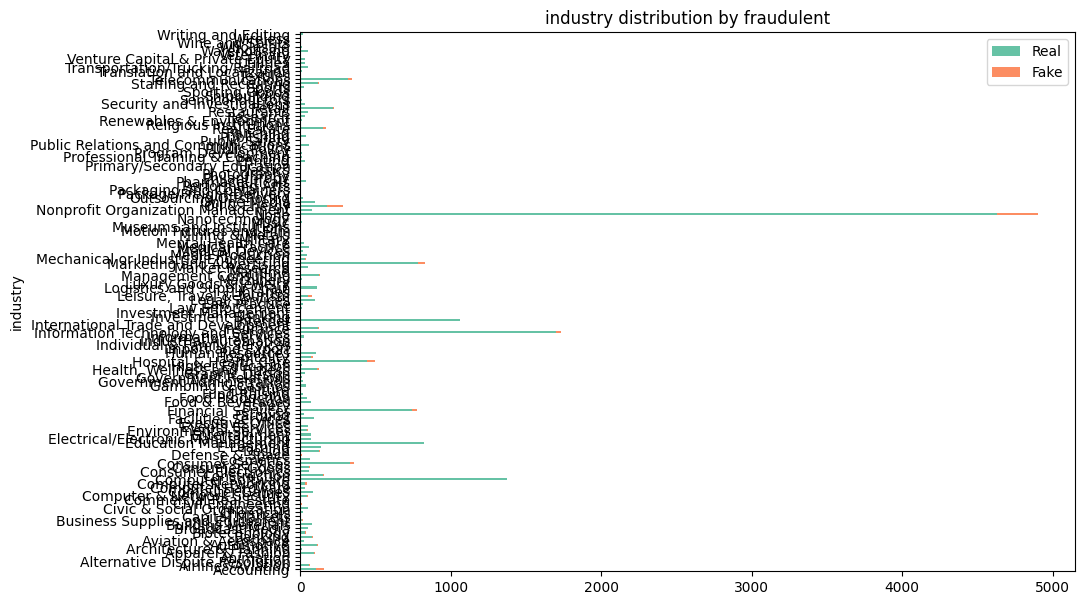

In [9]:
cat_label_plot('industry', cat_df, orient='h', stack=True)

위의 figure에서 볼 수 있듯이 하나의 figure에 담기에는 너무 많은 정보들이 존재함. 적당히 plot을 찍기 위해서 너무 소수로 존재하는 항목들은 data를 'None'으로 치환

In [10]:
# function to replace the values of colum. If the value is not in the given ratio, replace it with 'Other'

def replace_value(col, data, ratio):
    data = data.copy(deep = True)
    value = data[col].value_counts(normalize = True)
    replace = value[value < ratio].index
    data[col] = data[col].replace(replace, 'Other')
    return data

### Industry 분석

In [11]:
# industry의 unique 한 값들과 그 값들의 count 확인해보기

unique_industry = cat_df['industry'].unique()
unique_industry_count = cat_df['industry'].value_counts()
unique_industry_count.describe()

count     132.000000
mean      135.454545
std       483.524455
min         1.000000
25%         7.000000
50%        29.000000
75%        76.000000
max      4903.000000
Name: count, dtype: float64

In [12]:
# unique industry from only fake data

unique_industry_fake = only_fake['industry'].unique()
unique_industry_fake_count = only_fake['industry'].value_counts()
unique_industry_fake_count

industry
Oil & Energy                   109
Accounting                      57
Hospital & Health Care          51
Marketing and Advertising       45
Financial Services              35
                              ... 
Civic & Social Organization      1
Public Safety                    1
Wholesale                        1
Consumer Goods                   1
Online Media                     1
Name: count, Length: 62, dtype: int64

In [13]:
# unique industry from only real data
unique_industry_real = only_real['industry'].unique()
unique_industry_real_count = only_real['industry'].value_counts()
unique_industry_real_count

industry
Information Technology and Services    1702
Computer Software                      1371
Internet                               1062
Education Management                    822
Marketing and Advertising               783
                                       ... 
Museums and Institutions                  1
Sporting Goods                            1
Shipbuilding                              1
Alternative Dispute Resolution            1
Military                                  1
Name: count, Length: 130, dtype: int64

Fake와 real 데이터 간 industry 항목의 차이가 분명히 존재함

In [14]:
# function to replace the values of colum. If the value is under the given ratio, replace it with 'Other'
replace_value('industry', cat_df, 0.015)['industry'].value_counts() 

industry
None                                   4903
Other                                  4892
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Name: count, dtype: int64

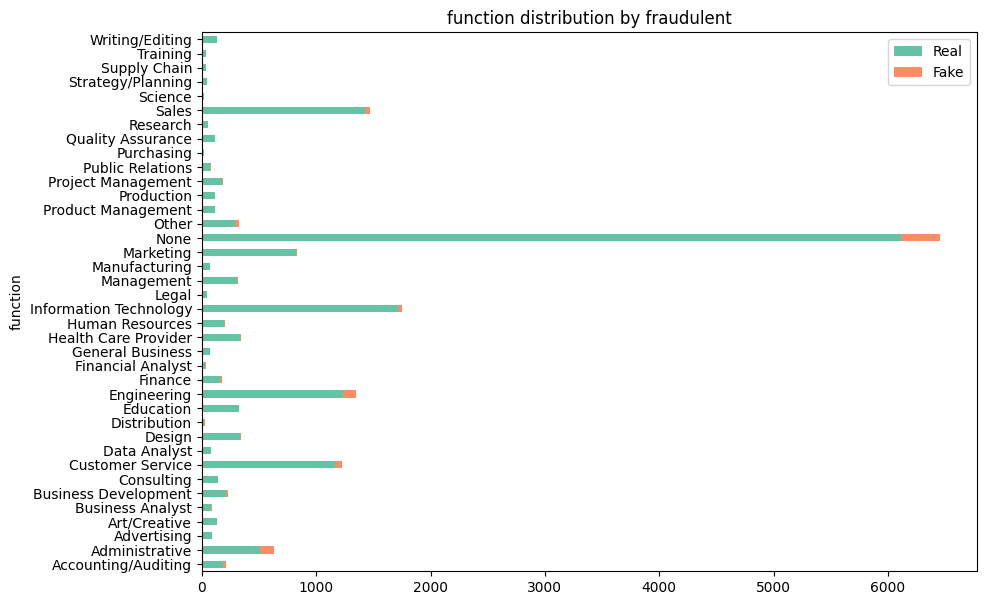

In [15]:
cat_label_plot('function', replace_value('industry', cat_df, 0.000001), r1=0, r2=90, stack=True, orient='h')

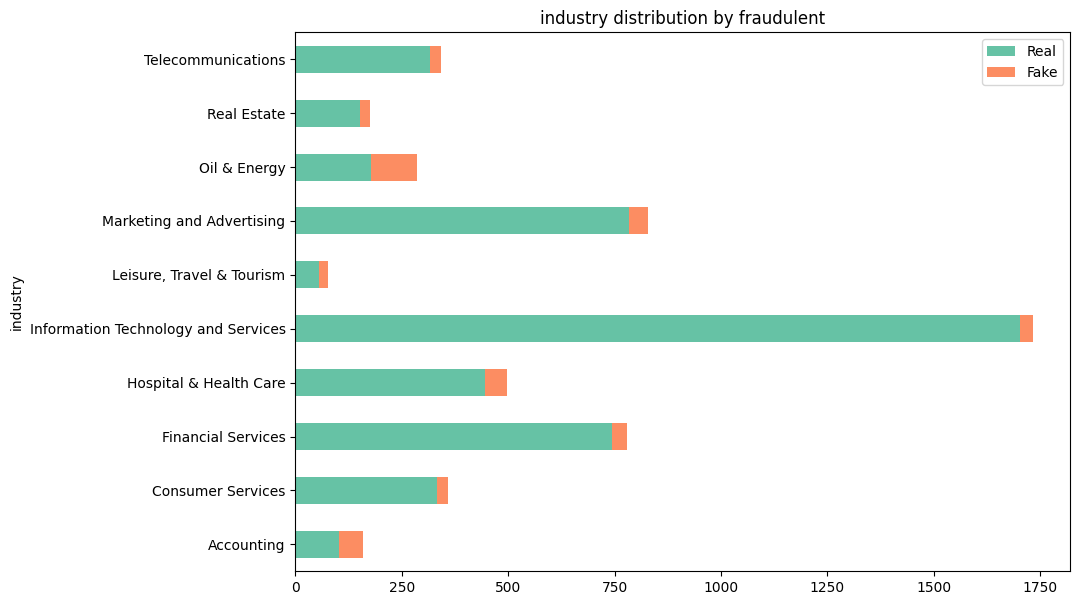

In [128]:
# only_fake에서 상위 10개의 industry에 대해서 원본 데이터를 가지고 plot 그려보기

top_10_industry_fake = only_fake['industry'].value_counts().head(10).index
top_10_industry_fake_mixed = cat_df[cat_df['industry'].isin(top_10_industry_fake)]
cat_label_plot('industry', top_10_industry_fake_mixed, r1=0, r2=90, stack=True, orient='h')

Industry가 'None'인 Fake job이 검출될 가능성이 다른 industry 보다 높다.

Engineering, Administrative, customer service에서 fake 검출이 비교적 높다

흥미로운 점은 기존 only_fake 데이터에서 상위에 rank된 industry 항목들 (Oil, hospital, etc.)은 위의 filtering을 한 번 한 표에는 충분한 샘플이 없는 관계로 집계되지 않음.

-> 이쪽 인코딩을 세 단계로 해보는 것은 어떨까?

i.e. 

0: Real job이 거의 대부분인 항목들 (writing, supply chain, management 등)

1: 해당 표에는 나타났는데 (= 어느정도 posting이 많이 생성되는데) fake의 비율이 좀 높은 항목들 (Engineering, Administrative, customer service 등)

2: 해당 표에는 없는데 그냥 fake job이 많이 올라온 항목들 (Oil, hospital 등)

숫자가 커질 수록 해당 industry에 fake job이 올라올 가능성이 높음을 의미하는 ordinal value

### Function 분석

In [124]:
# function의 unique 한 값들과 그 값들의 count 확인해보기
unique_function_count = cat_df['function'].value_counts()
unique_function_count.describe()

count      38.000000
mean      470.526316
std      1087.630172
min        14.000000
25%        69.500000
50%       132.000000
75%       325.000000
max      6455.000000
Name: count, dtype: float64

In [125]:
# unique function from only fake data
unique_function_fake_count = only_fake['function'].value_counts()
unique_function_fake_count


function
Administrative            119
Engineering               113
Customer Service           67
Sales                      41
Other                      32
Information Technology     32
Accounting/Auditing        29
Finance                    15
Business Development       13
Marketing                  10
Project Management         10
Human Resources             9
Management                  6
Financial Analyst           5
Advertising                 5
Consulting                  4
Data Analyst                4
Distribution                3
Design                      3
Manufacturing               2
Public Relations            1
Education                   1
Business Analyst            1
Strategy/Planning           1
General Business            1
Art/Creative                1
Health Care Provider        1
Name: count, dtype: int64

In [126]:
# unique function from only real data

unique_function_real_count = only_real['function'].value_counts()
unique_function_real_count


function
Information Technology    1717
Sales                     1427
Engineering               1235
Customer Service          1162
Marketing                  820
Administrative             511
Health Care Provider       337
Design                     337
Education                  324
Management                 311
Other                      293
Business Development       215
Human Resources            196
Accounting/Auditing        183
Project Management         173
Finance                    157
Consulting                 140
Writing/Editing            132
Art/Creative               131
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 85
Business Analyst            83
Data Analyst                78
Public Relations            75
Manufacturing               72
General Business            67
Research                    50
Legal                       47
Strategy/Planning           45
Training                    38

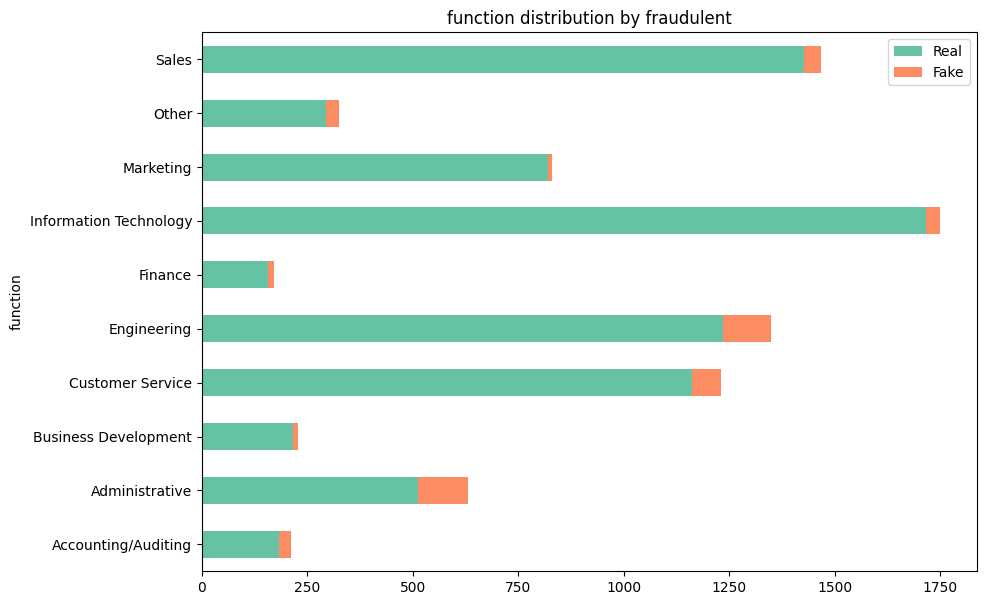

In [127]:
# only_fake에서 상위 10개의 function에 대해서 원본 데이터를 가지고 plot 그려보기

top_10_function_fake = only_fake['function'].value_counts().head(10).index
top_10_function_fake_mixed = cat_df[cat_df['function'].isin(top_10_function_fake)]
cat_label_plot('function', top_10_function_fake_mixed, r1=0, r2=90, stack=True, orient='h')

In [21]:
# function to replace the values of colum. If the value is under the given ratio, replace it with 'Other'
replace_value('function', cat_df, 0.015)['function'].value_counts() 

function
None                      6455
Other                     2851
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Education                  325
Management                 317
Name: count, dtype: int64

In [130]:
cat_df['function'].value_counts()

function
None                      6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46

In [129]:
cat_df['function'].unique()

array(['Marketing', 'Customer Service', 'None', 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

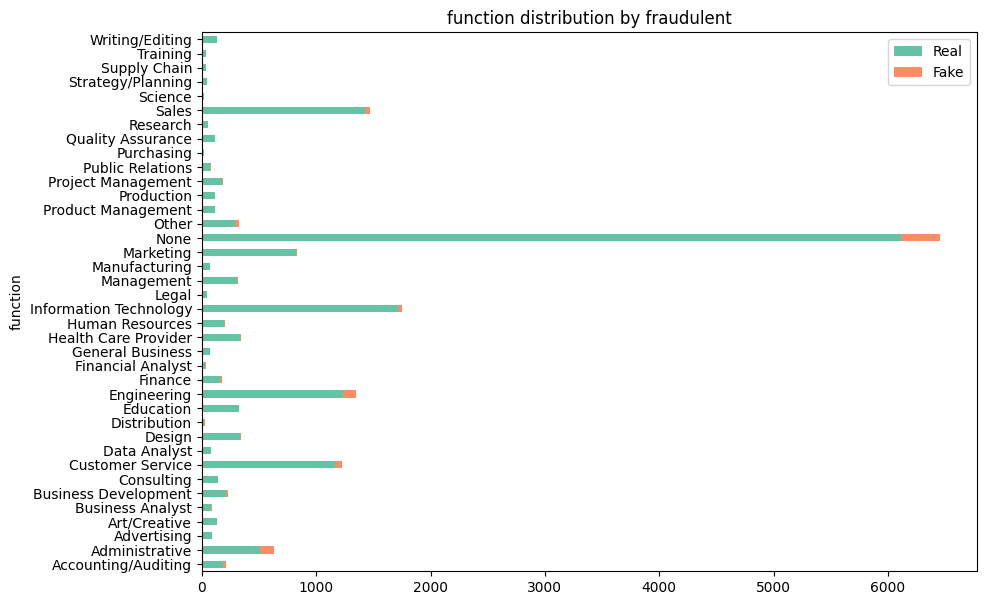

In [22]:
cat_label_plot('function', replace_value('function', cat_df, 0.0001), r1=0, r2=90, stack=True, orient='h')

### Required education 분석

In [23]:
# required education의 unique 한 값들과 그 값들의 count 확인해보기

unique_required_edu = cat_df['required_education'].unique()
unique_required_edu_count = cat_df['required_education'].value_counts()
unique_required_edu_count

required_education
None                                 8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64

In [24]:
# unique required education from only fake data
unique_req_edu_fake_count = only_fake['required_education'].value_counts()
unique_req_edu_fake_count


required_education
High School or equivalent            170
Bachelor's Degree                    100
Unspecified                           61
Master's Degree                       31
Some High School Coursework           20
Certification                         19
Associate Degree                       6
Professional                           4
Some College Coursework Completed      3
Doctorate                              1
Name: count, dtype: int64

In [25]:
# unique required education from only real data
unique_req_edu_real_count = only_real['required_education'].value_counts()
unique_req_edu_real_count


required_education
Bachelor's Degree                    5045
High School or equivalent            1910
Unspecified                          1336
Master's Degree                       385
Associate Degree                      268
Certification                         151
Some College Coursework Completed      99
Professional                           70
Vocational                             49
Doctorate                              25
Vocational - HS Diploma                 9
Some High School Coursework             7
Vocational - Degree                     6
Name: count, dtype: int64

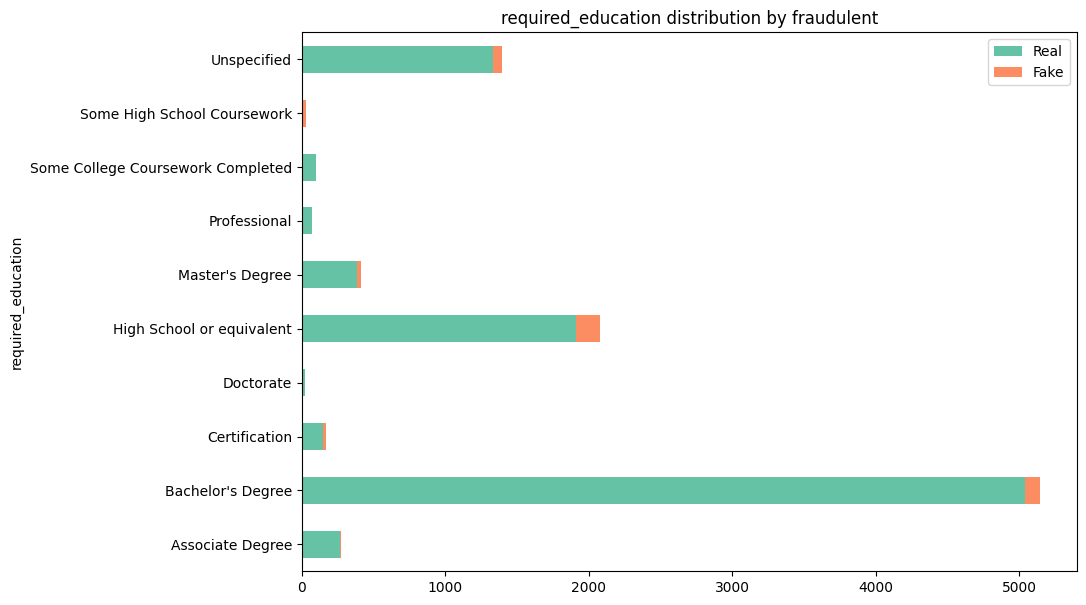

In [26]:
# only_fake에서 상위 10개의 required_education에 대해서 원본 데이터를 가지고 plot 그려보기

top_10_req_edu_fake = only_fake['required_education'].value_counts().head(10).index
top_10_req_edu_fake_mixed = cat_df[cat_df['required_education'].isin(top_10_req_edu_fake)]
cat_label_plot('required_education', top_10_req_edu_fake_mixed, r1=0, r2=90, stack=True, orient='h')


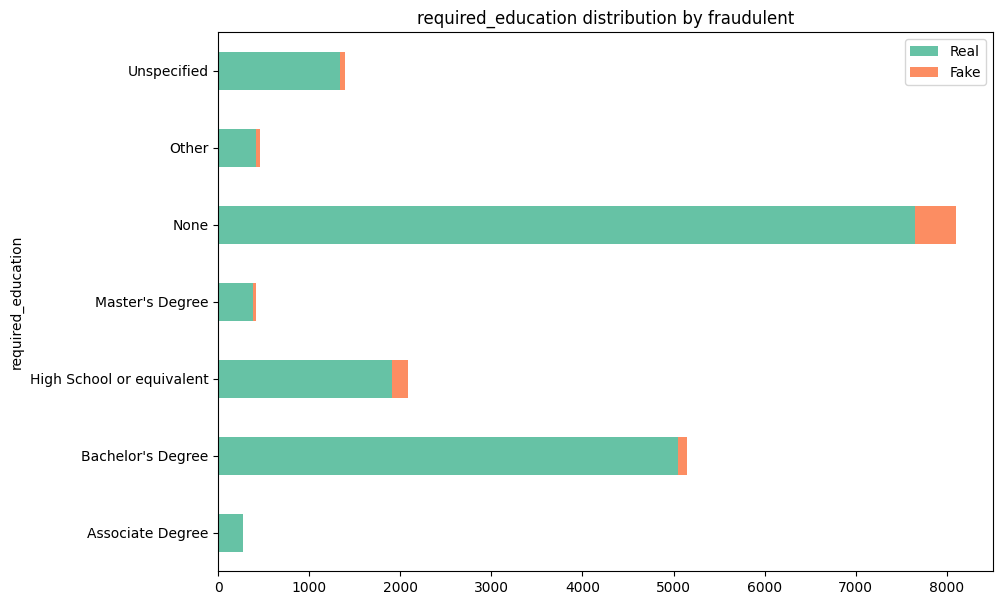

In [27]:
cat_label_plot('required_education', replace_value('required_education', cat_df, 0.01), r1=0, r2=90, stack=True, orient='h')

## 구글 Bard가 clustering한 결과



### jobs

* **Internship**
    * Not Applicable
    * None
* **Entry Level**
    * Associate
* **Mid-Senior Level**
    * Executive
    * Director


### Eduation

* **No formal education required:**
    * None
* **Secondary education:**
    * High School or equivalent
    * Some High School Coursework
* **Vocational education:**
    * Vocational
    * Vocational - Degree
    * Vocational - HS Diploma
* **Undergraduate education:**
    * Associate Degree
    * Bachelor's Degree
* **Graduate education:**
    * Master's Degree
    * Doctorate
    * Professional

### Industry

* **Business:**
    * Accounting
    * Advertising
    * Banking
    * Business supplies and equipment
    * Capital markets
    * Corporate finance
    * Economic development
    * Executive office
    * Financial services
    * Fund-raising
    * Investment management
    * Investment banking
    * Law practice
    * Management consulting
    * Market research
    * Nonprofit organization management
    * Public relations and communications
    * Securities
    * Venture capital and private equity
* **Education:**
    * Education management
    * Higher education
    * Primary/secondary education
* **Government:**
    * Government administration
    * Government relations
    * Law enforcement
    * Military
    * Public safety
* **Healthcare:**
    * Hospital and health care
    * Health, wellness, and fitness
    * Mental health care
    * Medical practice
    * Pharmaceutical research and development
    * Pharmacy
* **Hospitality:**
    * Airlines/aviation
    * Casinos
    * Food and beverage
    * Hospitality
    * Hotels and resorts
    * Restaurants
    * Travel and tourism
* **Information technology:**
    * Computer hardware
    * Computer networking
    * Computer software
    * Information technology and services
* **Media and entertainment:**
    * Advertising
    * Broadcasting
    * Graphic design
    * Motion pictures and film
    * Music
    * Publishing
    * Radio
    * Television
    * Video games
* **Professional and technical services:**
    * Architecture and planning
    * Biotechnology
    * Civil engineering
    * Computer engineering
    * Electrical engineering
    * Industrial engineering
    * Mechanical engineering
    * Mining and metals
    * Nanotechnology
    * Petroleum engineering
    * Robotics
* **Retail:**
    * E-commerce
    * Grocery
    * Online retail
    * Retail
    * Wholesale
* **Science and engineering:**
    * Aerospace engineering
    * Chemistry
    * Environmental engineering
    * Materials science
    * Physics
    * Renewable energy
* **Social services:**
    * Individual and family services
    * Nonprofit organization management
    * Social work
* **Transportation:**
    * Automotive
    * Aviation
    * Maritime
    * Railroad
    * Shipping
    * Trucking
* **Other:**
    * Construction
    * Farming
    * Fishing
    * Forestry
    * Manufacturing
    * Mining
    * Oil and gas
    * Real estate
    * Warehousing

### Function

* **Business:**
    * Accounting/Auditing
    * Business development
    * Business analyst
    * Consulting
    * Finance
    * General business
    * Management
    * Marketing
    * Operations
    * Product management
    * Public relations
    * Sales
    * Strategy/planning
    * Supply chain
    * Training
    * Human resources

* **Engineering:**
    * Civil engineering
    * Computer engineering
    * Electrical engineering
    Mechanical engineering
    Engineering

* **Information Technology:**
    * Computer networking
    * Computer programming
    * Computer support
    * Information technology
    * Information security

* **Other:**
    * Art/Creative
    * Data analyst
    * Education
    * Legal
    * Manufacturing
    * Quality assurance
    * Research
    * Science
    * Writing/editing

* **Healthcare:**
    * Health care provider

* **Administrative:**
    * Administrative assistant
    * Customer service
    * Human resources
    * Office manager
    * Receptionist

* **Design:**
    * Graphic design
    * Interior design
    * Web design

* **Production:**
    * Audio production
    * Film production
    * Manufacturing
    * Music production
    * Video production

* **Distribution:**
    * Logistics
    * Purchasing
    * Warehousing

### Task 5

Required education을 굳이...? ordinal하게 볼 필요가 있을까?

### Task 7

In [29]:
all_cat_cols = cat_df.columns
all_cat_cols


Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [135]:
import collections
import math

# 범주형 데이터 플롯 함수
def cat_ratio_plot_based_on_real_fake(col, data, r1=0, r2=0, stack=True, orient='v', label_bar=False):
  def plot_one(_col, ax):
    if not stack:  
      if orient == 'v':
        sns.countplot(x = 'fraudulent', data = data, hue = _col, ax = ax)
        
      else:
        sns.countplot(y = 'fraudulent', data = data, hue = _col, ax = ax)
      
    else:
      _df = data.groupby([_col, 'fraudulent']).size().unstack().T
      
      # normalize the values
      _df = _df.div(_df.sum(axis = 1), axis = 0)
      
      # replace 1 with Fake and 0 with Real for the values
      _df.index = ['Real', 'Fake']
      
      # replace any binary columns with True and False
      _df = _df.rename(columns = {0: 'False', 1: 'True'}, inplace = False)
      
      if orient == 'v':
        _type = 'bar'
        
      else:
        _type = 'barh'
        
      _df.plot(kind = _type, stacked = True, ax = ax)
      
    # set the y label as Real for 0 and Fake for 1
        
    size = []
    
    for p in ax.patches:
      h = p.get_height()
      size.append(h)
      w = p.get_width()
      x = p.get_x()
      
      if label_bar:
        ax.text(x + w/2, h + 5, '{:1.2f}%'.format(h/len(data)*100), ha = 'center', rotation = r2)
    
    ax.set_title('{} distribution by fraudulent'.format(_col))
                
  if isinstance(col, str):
    # plot only one figure
    fig, ax = plt.subplots(figsize = (10, 7))
    plot_one(col, ax)
    
  elif isinstance(col, collections.abc.Iterable):
    NUM_FIGS_IN_ROW = 2
    num_rows = math.ceil(len(all_cat_cols)//NUM_FIGS_IN_ROW)
    fig, axes = plt.subplots(num_rows, NUM_FIGS_IN_ROW, figsize = (25, 10*num_rows))
    sns.set_palette('Set2')
    
    # iterate over all columns and plot them
    for i, _col in enumerate(col):
      plot_one(_col, axes[i//NUM_FIGS_IN_ROW, i%NUM_FIGS_IN_ROW])
  
  # set the maximum number of legends to 10
  for ax in axes.flatten():
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:10], l[:10])

  plt.show()

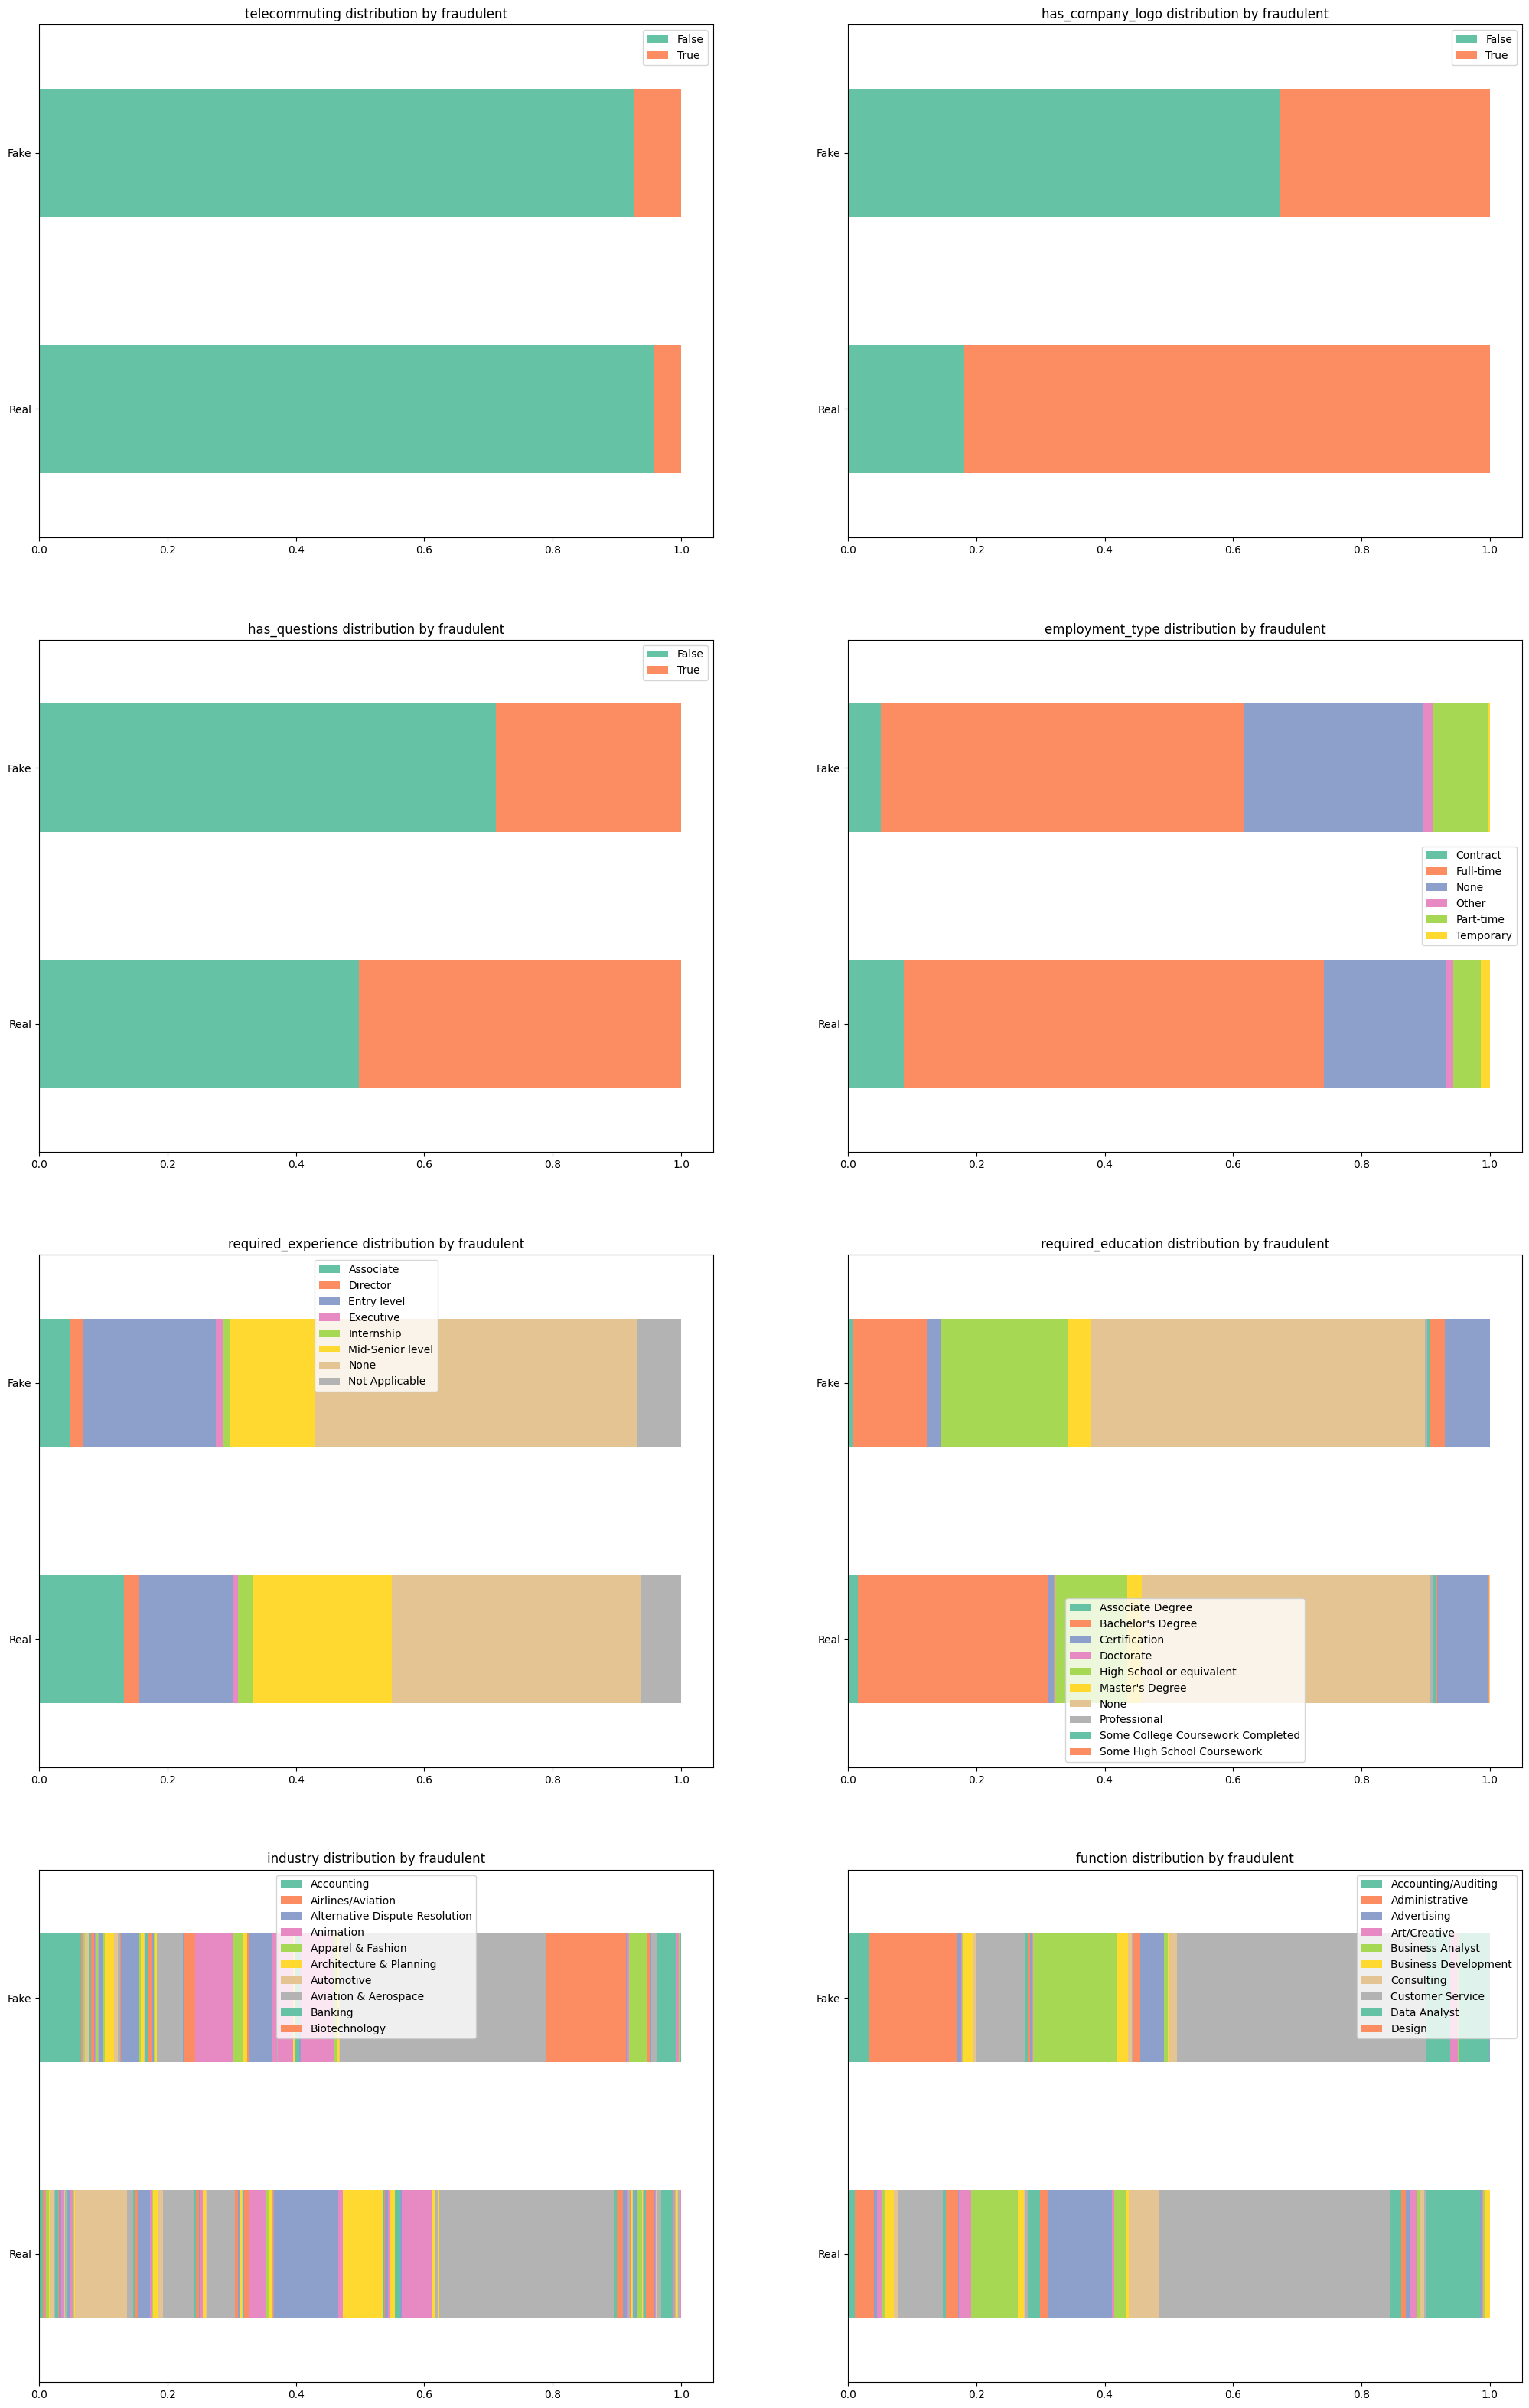

In [136]:
cat_ratio_plot_based_on_real_fake(all_cat_cols[:-1], cat_df, r1=0, r2=90, stack=True, orient='h')

In [ ]:
cat_label_plot(df)

### Task 8 - 문장 길이별 Real/Fake 조사

title, company_profile, description, requirements, benefits에 대해서 문장 길이 조사

In [28]:
cols = list(text_df.columns)
cols.remove('fraudulent')

text_df[cols]

,title,company_profile,description,requirements,benefits
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered
...,...,...,...,...,...
17875,Account Director - Distribution,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...
17876,Payroll Accountant,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...
17877,Project Cost Control Staff Engineer - Cost Con...,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,
17878,Graphic Designer,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...


In [30]:
def count_setence_length(text):
    # calculate the average length of a full sentences in the text
    
    length = []
    
    try:
        for i in text:
            length.append(len(i.split(".")))

    except:
        print("")
    return np.mean(length)

In [31]:
# average length of a full sentences in the text for the text_df
# set the avergae length of a text in the column
text_with_length = text_df.copy(deep = True)

for col in cols:
    text_with_length[f"{col}_length"] = text_with_length[col].apply(count_setence_length)


In [32]:
text_with_length

,title,company_profile,description,requirements,benefits,fraudulent,title_length,company_profile_length,description_length,requirements_length,benefits_length
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1.0,1.009040,1.001105,1.000000,1.000000
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1.0,1.004666,1.007222,1.002094,1.004644
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1.0,1.005688,1.008451,1.010271,1.000000
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1.0,1.006515,1.002692,1.000000,1.001279
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1.0,1.008600,1.001974,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1.0,1.009368,1.005548,1.001571,1.011669
17876,Payroll Accountant,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1.0,1.009251,1.003289,1.005548,1.000000
17877,Project Cost Control Staff Engineer - Cost Con...,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,1.0,1.008772,1.003873,1.004858,1.000000
17878,Graphic Designer,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,1.0,1.000000,1.009881,1.017928,1.000000


In [38]:
# statistics over the fraudulent column
text_with_length[[f"{c}_length" for c in cols] + ['fraudulent']].groupby('fraudulent').mean()

,title_length,company_profile_length,description_length,requirements_length,benefits_length
fraudulent,,,,,
0,1.001255,1.005888,1.006306,1.005098,1.004241
1,1.001594,1.002285,1.008094,1.006423,1.004356


In [36]:
text_with_length[[f"{c}_length" for c in cols] + ['fraudulent']].groupby('fraudulent').std()

,title_length,company_profile_length,description_length,requirements_length,benefits_length
fraudulent,,,,,
0,0.007796,0.003923,0.003737,0.012738,0.01159
1,0.008048,0.004308,0.005061,0.008228,0.00899


### T, p test 어떻게 할 수 있나?

### Task 12 - 원본 텍스트에 n-gram 적용해보기

In [45]:
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


In [54]:
text_df.columns

Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'fraudulent'],
      dtype='object')

In [55]:
title_df = text_df[['title', 'fraudulent']]
company_profile_df = text_df[['company_profile', 'fraudulent']]
description_df = text_df[['description', 'fraudulent']]
requirements_df = text_df[['requirements', 'fraudulent']]
benefits_df = text_df[['benefits', 'fraudulent']]

In [62]:
from nltk.util import ngrams

def get_top_k_with_n_gram(corpus, n=2, k=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

def plot_top_k_with_n_gram(text, n=2, k=20):
    top_k = get_top_k_with_n_gram(text, n, k)
    x,y=map(list,zip(*top_k))
    sns.barplot(x=y,y=x)
    
    plt.title(f'Top {k} most common {n}-grams in text')
    plt.ylabel(' ')
    plt.tight_layout()
    plt.show()
    
def plot_top_k_with_n_gram_by_target(mixed, n=2, k=20):
    real = mixed[mixed['fraudulent'] == 0]
    fake = mixed[mixed['fraudulent'] == 1]
    
    real_text = real[real.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
    fake_text = fake[fake.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
    
    real_top_k = get_top_k_with_n_gram(real_text, n, k)
    fake_top_k = get_top_k_with_n_gram(fake_text, n, k)
    
    real_x,real_y=map(list,zip(*real_top_k))
    fake_x,fake_y=map(list,zip(*fake_top_k))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.barplot(x=real_y,y=real_x, ax=axes[0])
    axes[0].set_title(f'Top {k} most common {n}-grams in real text')
    axes[0].set_ylabel(' ')
    axes[0].set_xlabel(' ')
    
    sns.barplot(x=fake_y,y=fake_x, ax=axes[1])
    axes[1].set_title(f'Top {k} most common {n}-grams in fake text')
    axes[1].set_ylabel(' ')
    axes[1].set_xlabel(' ')
    
    plt.tight_layout()
    plt.show()

### Naive gram plot on mixed data

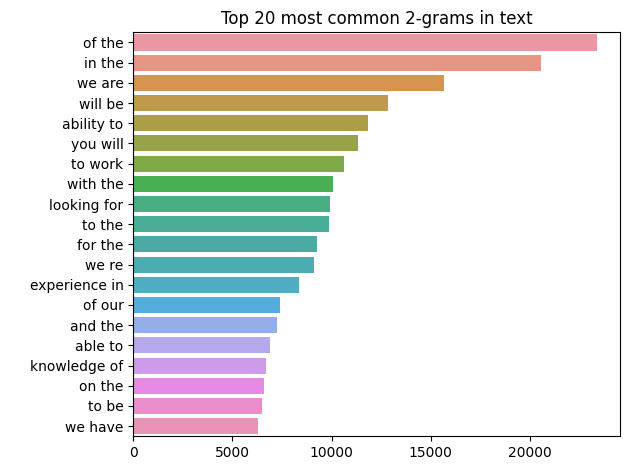

In [49]:
plot_top_k_with_n_gram(text, n=2, k=20)

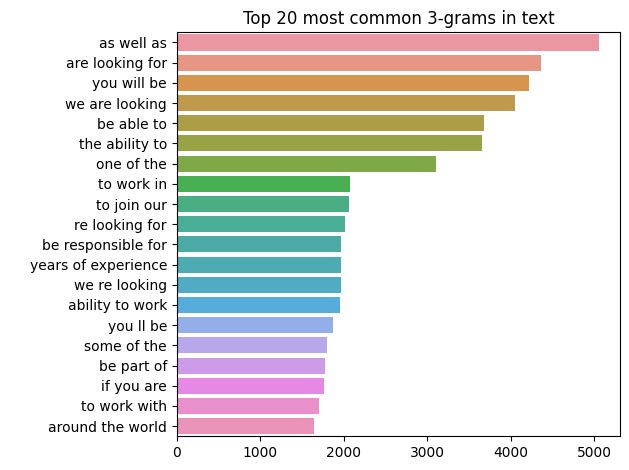

In [50]:
plot_top_k_with_n_gram(text, n=3, k=20)

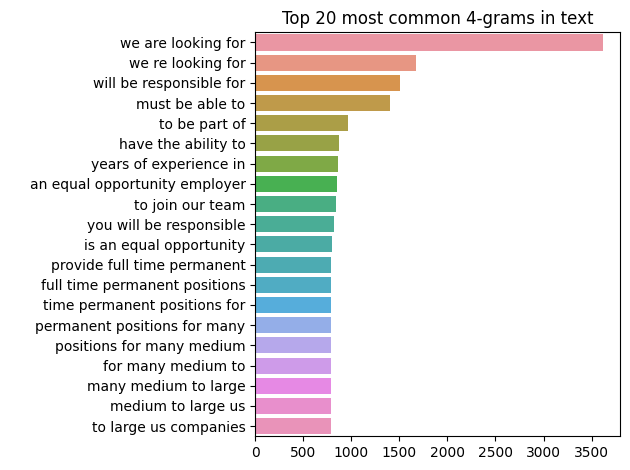

In [51]:
plot_top_k_with_n_gram(text, n=4, k=20)

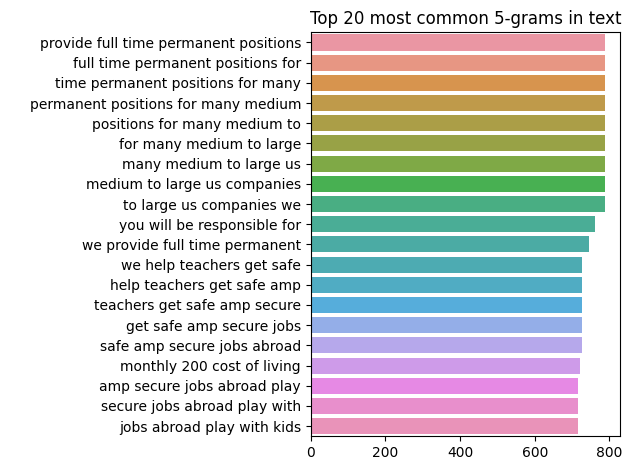

In [52]:
plot_top_k_with_n_gram(text, n=5, k=20)

### Seperate n gram analysis

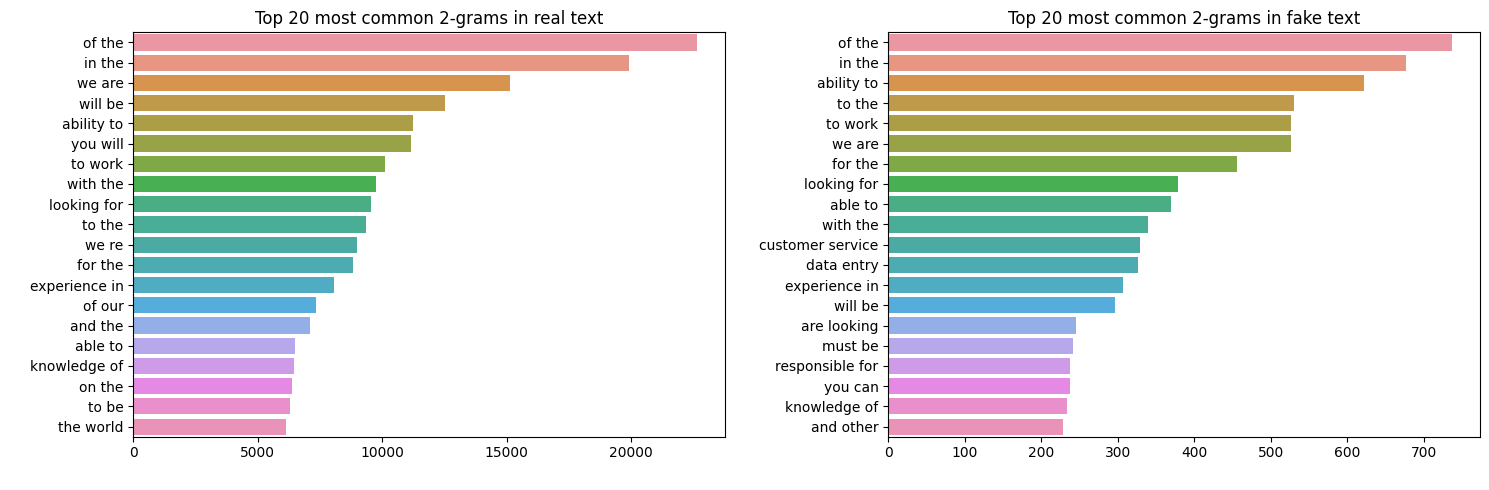

In [63]:
plot_top_k_with_n_gram_by_target(text_df, n=2, k=20)

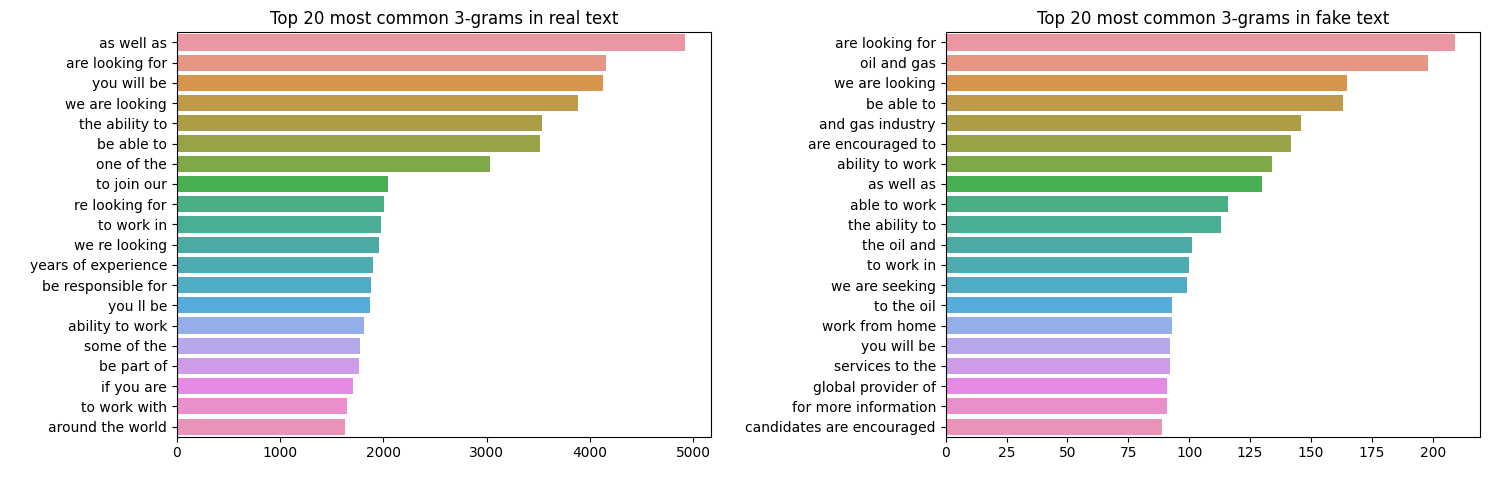

In [64]:
plot_top_k_with_n_gram_by_target(text_df, n=3, k=20)

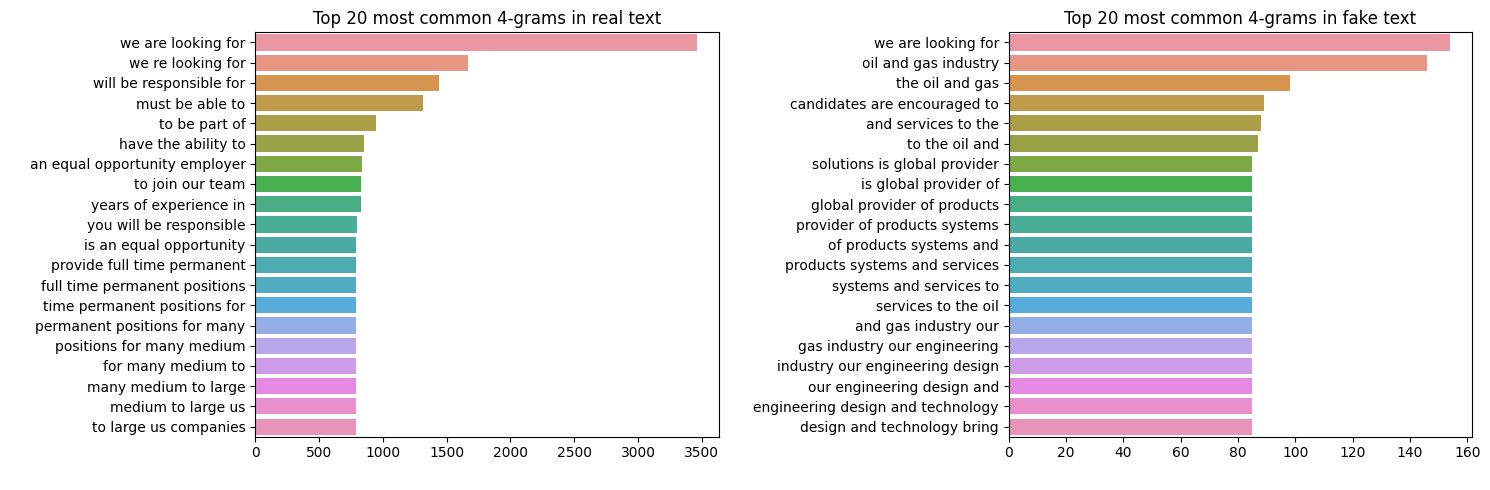

In [65]:
plot_top_k_with_n_gram_by_target(text_df, n=4, k=20)

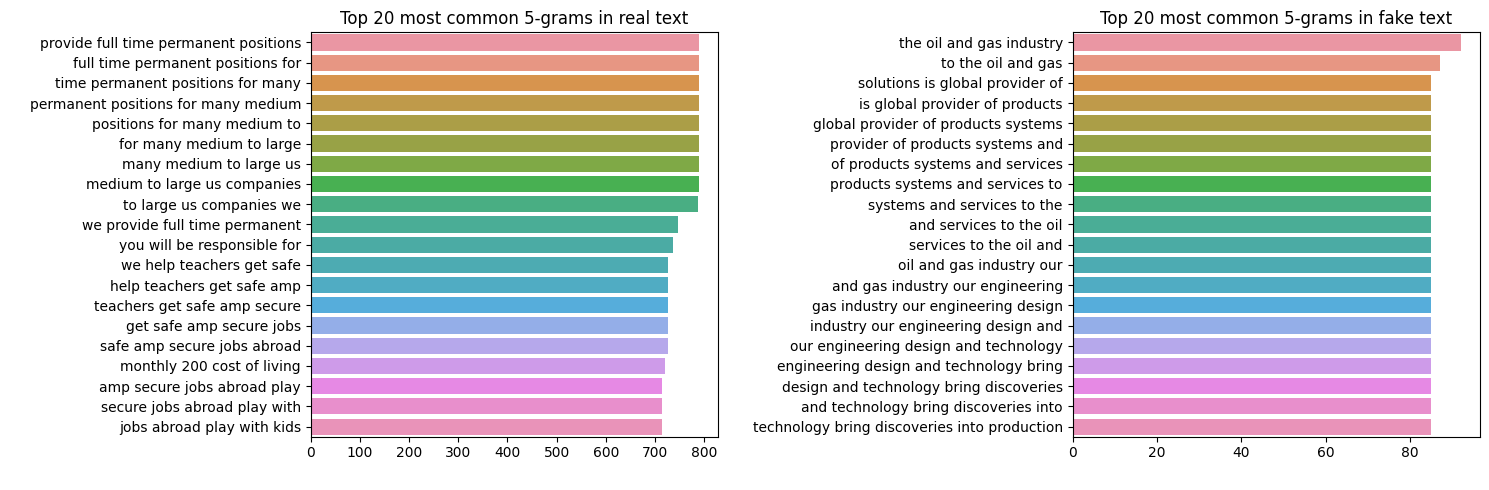

In [66]:
plot_top_k_with_n_gram_by_target(text_df, n=5, k=20)

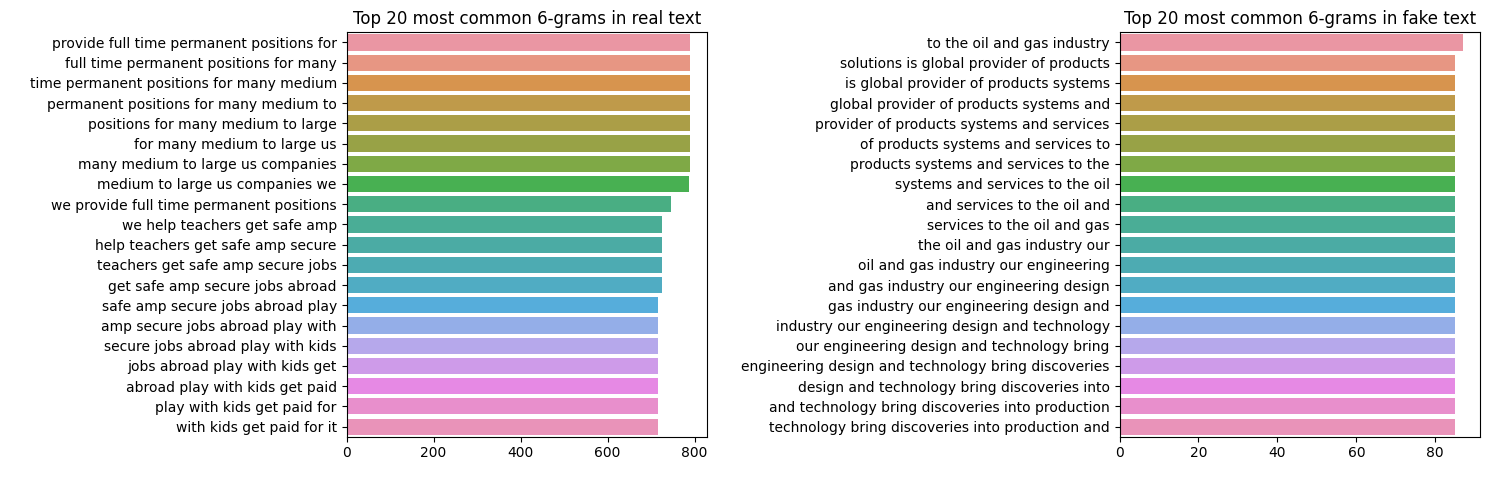

In [67]:
plot_top_k_with_n_gram_by_target(text_df, n=6, k=20)

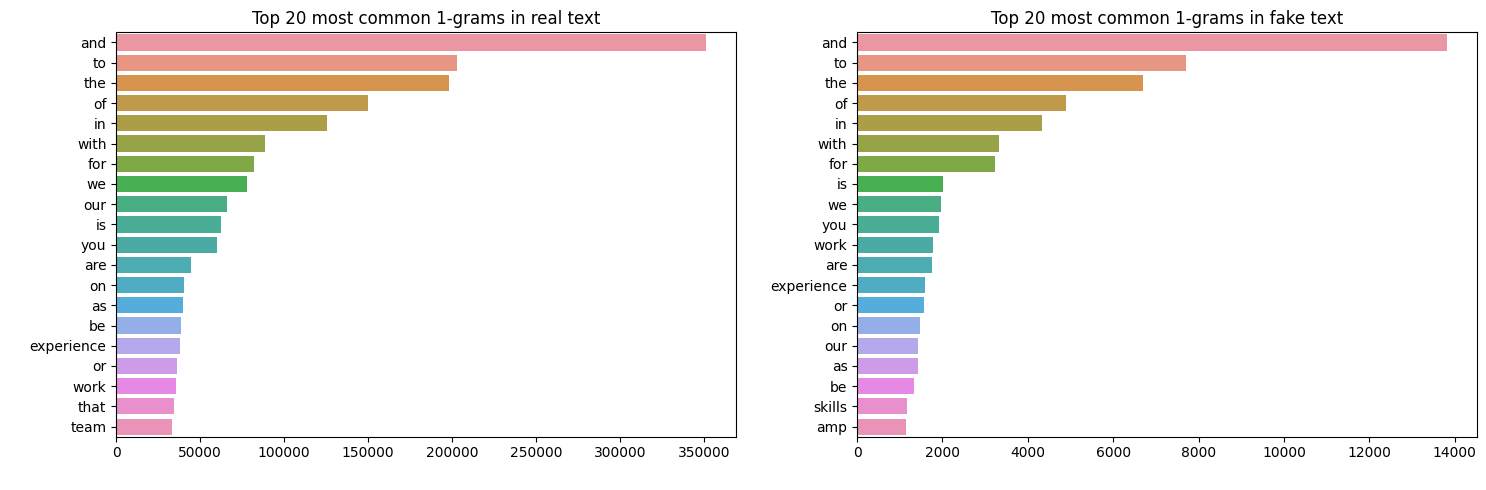

In [68]:
plot_top_k_with_n_gram_by_target(text_df, n=1, k=20)